<a href="https://colab.research.google.com/github/jagadish9084/learnbay-ds-ml-course/blob/main/supervised/linear_regression/student_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [495]:
#https://www.kaggle.com/datasets/haseebindata/student-performance-predictions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# Exploratory Data Analysis(EDA)

## Laod the data

In [496]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/learnbay-ds-ml-course/datasets/student_performance.csv')

## Data Inspection
Review the data to understand its structure, data types and general content

In [497]:
data.head()

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85


In [498]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   StudentID                  10 non-null     int64 
 1   Name                       10 non-null     object
 2   Gender                     10 non-null     object
 3   AttendanceRate             10 non-null     int64 
 4   StudyHoursPerWeek          10 non-null     int64 
 5   PreviousGrade              10 non-null     int64 
 6   ExtracurricularActivities  10 non-null     int64 
 7   ParentalSupport            10 non-null     object
 8   FinalGrade                 10 non-null     int64 
dtypes: int64(6), object(3)
memory usage: 848.0+ bytes


There are 3 categorical columns and 5 numerical columns.

## Handling Missing Values

In [499]:
data.isna().sum()

,0
StudentID,0
Name,0
Gender,0
AttendanceRate,0
StudyHoursPerWeek,0
PreviousGrade,0
ExtracurricularActivities,0
ParentalSupport,0
FinalGrade,0


As you can see above, there are no missing values hence no need to drop or impute missing values

## Removing Duplicates
Find and remove duplicate that can skew the analysis.

In [500]:
print(f'Duplicate rows: {data.duplicated().sum()}')

Duplicate rows: 0


## Outlier Detection and Treatment
Use visualisation techniques(bar plot) to spot the outlier

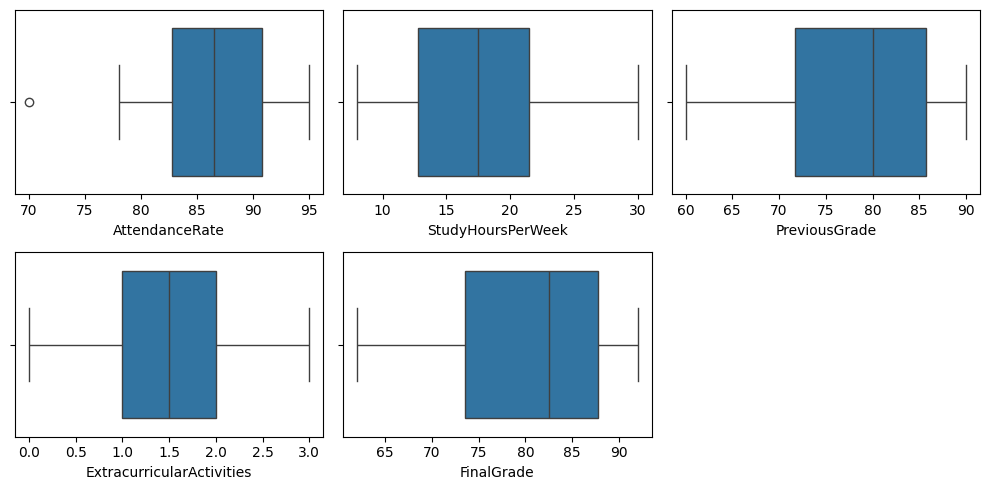

In [501]:
data_copy = data.select_dtypes(np.number).drop(['StudentID'], axis=1)
figure, ax = plt.subplots(2, 3, figsize=(10, 5))
ax[1, 2].remove()
for index, col in enumerate(data_copy.columns):
  sns.boxplot(ax = ax[index//3, index%3], x = col, data = data_copy)
figure.tight_layout()
figure.show()


AttendanceRate columns as an outlier hence we need to treat this column.

In [502]:
attendence = data.AttendanceRate
min, max = attendence.min(), attendence.max()
q1, q3 = attendence.quantile(.25), attendence.quantile(.75)
iqr = q3 - q1
upper_bound, lower_bound = (q1 - iqr*1.5), q3 + 1.5*iqr
print(f'Min:{min}, Max:{max}, Q1:{q1}, Q3:{q3}, IQR, {iqr}, UB:{upper_bound}, LB:{lower_bound}')
data.AttendanceRate = data.AttendanceRate.clip(lower_bound, upper_bound)

Min:70, Max:95, Q1:82.75, Q3:90.75, IQR, 8.0, UB:70.75, LB:102.75


Check of outlier is Treated

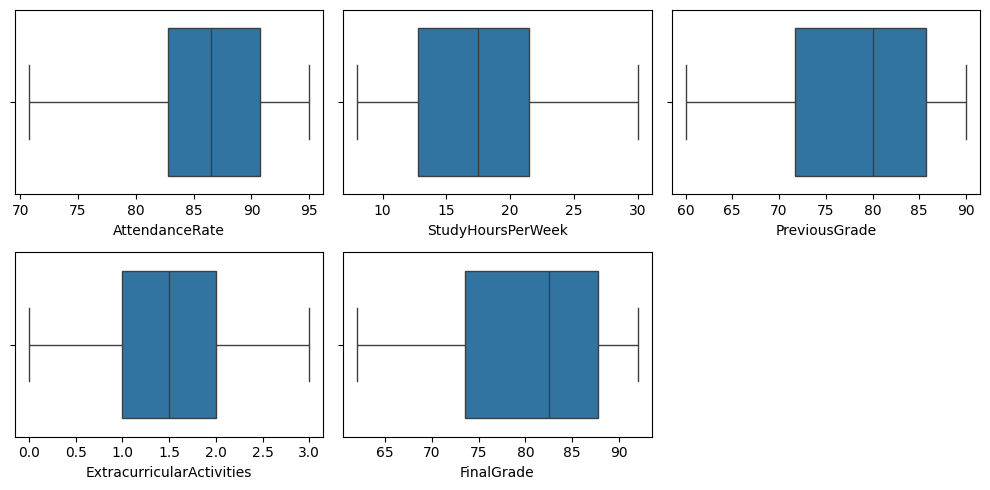

In [503]:
data_copy = data.select_dtypes(np.number).drop(['StudentID'], axis=1)
figure, ax = plt.subplots(2, 3, figsize=(10, 5))
ax[1, 2].remove()
for index, col in enumerate(data_copy.columns):
  sns.boxplot(ax = ax[index//3, index%3], x = col, data = data_copy)
figure.tight_layout()
figure.show()


## Drop irrelevant columns
Name and StrudentID columns do not have any impact on predicting the target hence drop these 2 columns

In [504]:
data.drop(['Name','StudentID'], axis=1, inplace=True, errors = 'ignore')
print(f'Columns to be used for prediction: {data.columns}')

Columns to be used for prediction: Index(['Gender', 'AttendanceRate', 'StudyHoursPerWeek', 'PreviousGrade',
       'ExtracurricularActivities', 'ParentalSupport', 'FinalGrade'],
      dtype='object')


## Encoding Categorical Variables


**Gender** column is nominal in nature hence encode this column using OneHotEncoder

In [505]:
encoder = OneHotEncoder(drop='first', dtype='int', sparse_output=False)
data[['Gender']]= encoder.fit_transform(data[['Gender']])
data.head(2)

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,85.0,15,78,1,High,80
1,0,90.0,20,85,2,Medium,87


ParentalSupport is ordinal in nature hence we should encode this column using Label encoder.

**Label Encoder does not have capabilities to set specific label for each category, we have to implement custom logic for Label encoding**.

In [506]:
labels = {'Low': 1, 'Medium': 2, 'High': 3}
data['ParentalSupport'] = data.ParentalSupport.map(labels)
data.head(3)

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,85.0,15,78,1,3,80
1,0,90.0,20,85,2,2,87
2,1,78.0,10,65,0,1,68


## Correlation Analysis
A correlation matrix is a matrix that summarizes the strength and direction of the linear relationships between pairs of variables in a dataset.
The correlation is directly proportional if the values are positive, and inversely proportional if the values are negative.

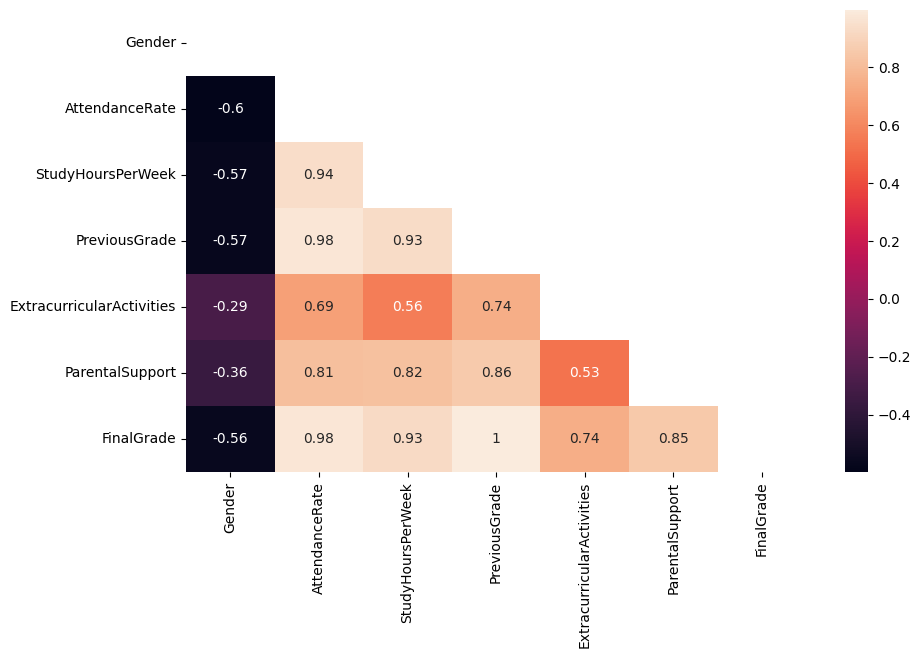

In [507]:
figure, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.heatmap(ax=ax, data = data.corr(), mask=np.triu(data.corr()), annot=True)
figure.show()

From the above matrix we infer thta the target variable FinalGrade has strong correlation with AttendanceRate, StrudyHourcePerWeek, PreviousGrade, ExtracurriculamActivities and Parental support

# Pre Processing

## Split training and testing data

In [508]:
x = data.drop(['FinalGrade', 'Gender'], axis=1)
y = data['FinalGrade']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Dimension of x_train: {x_train.shape}')
print(f'Dimension of x_test: {x_test.shape}')
print(f'Dimension of y_train: {y_train.shape}')
print(f'Dimension of y_test: {y_test.shape}')

Dimension of x_train: (8, 5)
Dimension of x_test: (2, 5)
Dimension of y_train: (8,)
Dimension of y_test: (2,)


## Normalise the data
Scale numerical data to a standard range or distribution. This can be achieved using techniques like z-score.

It is recommended that we should normalize the data after splitting it into training and testing sets. The rationale behind this recommendation is to prevent any information leakage from the testing set into the training set, which can lead to over-optimistic results and unrealistic performance evaluations.

In [509]:
scalar = StandardScaler()
scalar.fit(x_train)
x_train_scaled = pd.DataFrame(scalar.transform(x_train), columns=scalar.get_feature_names_out())
x_test_scaled = pd.DataFrame(scalar.transform(x_test), columns=scalar.get_feature_names_out())

In [510]:
x_train_sm = sm.add_constant(x_train_scaled)
lr = sm.OLS(np.array(y_train), x_train_sm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     160.0
Date:                Tue, 03 Sep 2024   Prob (F-statistic):            0.00622
Time:                        14:13:06   Log-Likelihood:                -5.8165
No. Observations:                   8   AIC:                             23.63
Df Residuals:                       2   BIC:                             24.11
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

From the above regression results, we infer that none of the predictors are statistically significant due to high P values(P < 0.05).

Strong correlation bewtween predictors (multicollinearity) could be the reason for inflated p values.


## Testing for Multicollinearity with VIF method


In [511]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [512]:
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [round(variance_inflation_factor(x_train.values, idx), 2) for idx in range(x_train.shape[1])]
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,Features,VIF
2,PreviousGrade,7813.81
0,AttendanceRate,5996.22
4,ParentalSupport,49.97
1,StudyHoursPerWeek,41.44
3,ExtracurricularActivities,21.56


All the varibales have very high multicollinearity ( > 5), Lets Drop column with high multicollinearity(PreviousGrade) and then and rebuild the model

# Make the test Predictions

In [513]:
# stats model will not add constant if data is already has a constant, Here in this case ExtracurricularActivities has constants,
# We need to enforce model to add constant by setting has_constant attribute to 'add'
x_test_data = sm.add_constant(x_test_scaled, has_constant='add')
y_pred = lr.predict(x_test_data)
y_pred

,0
0,73.351774
1,87.505081
